# LRP

Implementation of Layer-wise Relevance Propagation (LRP) in PyTorch.

Note:
Max-pooling layers are handled using the winner-takes-all strategy and not the sum-pooling-layer-rules strategy.

## Setup

Load model and input data.

In [1]:
from lrp import image
from torchvision import transforms
from typing import Callable
import torchvision
import numpy
import torch
from lrp import norm, image

# Normalization
norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ImageNetNorm()

# Input data
# img: numpy.array = image.load_normalized_img('data/castle.jpg')
# X: torch.Tensor = norm_fn(image.img_to_tensor(img))

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean, std)
])

inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('data/castle2.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Omit printing the model
None


Variables for $z^\mathcal{B}$-Rule

In [2]:
from typing import Tuple

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

## Rule-Layer Mapping

Define helpers for mapping rules to layers.

In [3]:
from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

## Heatmap

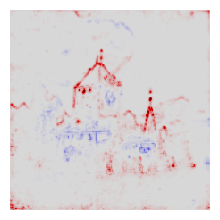

In [4]:
from lrp.core import LRP

lrp = LRP(model)
lrp.convert_layers(name_map)
R: torch.Tensor = lrp.relevance(X)
lrp.heatmap(R, width=2, height=2)

## Debug Mapping

In [5]:
lrp.model

VGG(
  (features): Sequential(
    (0): LrpZBoxRule(
      (layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (low_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (high_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): LrpGammaRule(
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LrpGammaRule(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): ReLU(inplace=True)
    (7): LrpGammaRule(
      (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv

In [6]:
for layers, rule, params in name_map:
    for layer in layers:
        print(f'{layer} {rule.__name__}')

features.0 LrpZBoxRule
features.2 LrpGammaRule
features.5 LrpGammaRule
features.7 LrpGammaRule
features.10 LrpGammaRule
features.12 LrpGammaRule
features.14 LrpGammaRule
features.17 LrpEpsilonRule
features.19 LrpEpsilonRule
features.21 LrpEpsilonRule
features.24 LrpEpsilonRule
features.26 LrpEpsilonRule
features.28 LrpEpsilonRule
avgpool LrpZeroRule
classifier.0 LrpZeroRule
classifier.3 LrpZeroRule
classifier.6 LrpZeroRule


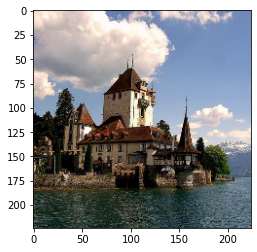

In [7]:
from matplotlib import pyplot as plt

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img: numpy.array = image.load_normalized_img('data/castle2.jpg')
X = transform(img)

# PyTorch modules processing image data expect tensors in the format C × H × W
# Whereas PILLow and Matplotlib expect image arrays in the format H × W × C
# Source: https://stackoverflow.com/a/66641911
plt.imshow(inv_norm(X).numpy().transpose((1, 2, 0)))